In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/train-komen-label-2/train komen label 2.xlsx


In [1]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
print("Device name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU")


Using device: cuda
Device name: Tesla T4


In [5]:
# -*- coding: utf-8 -*-
# === IndoBERT for Imbalanced Classification ===

# Install dependency (aktifkan jika perlu)
#!pip install -q transformers datasets scikit-learn pandas openpyxl



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 5.1 MB/s eta 0:00:00ta 0:00:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.8.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12 12.5.82 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-nvrtc-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-nvrtc-cu12 12.5.82 which is incom

# Syntax Ori

# two stage classification

In [1]:
import pandas as pd
import numpy as np
import torch
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding,
    EarlyStoppingCallback
)
from datasets import Dataset
from torch import nn
from collections import Counter
from sklearn.utils import resample

2025-08-02 10:19:16.986901: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754129957.351899      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754129957.460277      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# ============================
# 1. Load dataset
# ============================
df = pd.read_csv("/kaggle/input/good-quality-data/train - Good data train generated.csv")
df = df.dropna(subset=["Comment", "Category"])

# ============================
# 2. Buat label main (3 kelas)
# ============================
def map_main_label(cat):
    if cat == "Feedback Positive":
        return "Feedback Positive"
    elif cat == "Uncategorized":
        return "Uncategorized"
    else:
        return "Suggestion"

df["main_label"] = df["Category"].apply(map_main_label)

label_encoder_main = LabelEncoder()
df["label_main"] = label_encoder_main.fit_transform(df["main_label"])

id2label_main = {i: label for i, label in enumerate(label_encoder_main.classes_)}
label2id_main = {label: i for i, label in id2label_main.items()}

# Dataset multiclass (22 kategori hanya Suggestion)
df_multiclass = df[df["main_label"] == "Suggestion"].copy()

label_encoder_22 = LabelEncoder()
df_multiclass["label_22"] = label_encoder_22.fit_transform(df_multiclass["Category"])

id2label_22 = {i: label for i, label in enumerate(label_encoder_22.classes_)}
label2id_22 = {label: i for i, label in id2label_22.items()}

# ============================
# Oversampling tahap 1 (3 kelas)
# ============================
print("Distribusi tahap 1 sebelum oversampling:", Counter(df["main_label"]))

df_fp = df[df["main_label"] == "Feedback Positive"]
df_un = df[df["main_label"] == "Uncategorized"]
df_sg = df[df["main_label"] == "Suggestion"]

# Ambil target jumlah untuk minoritas (50% dari mayoritas)
target_count = int(0.5 * len(df_fp))

df_un_oversampled = resample(df_un,
    replace=True,
    n_samples=min(target_count, len(df_fp)),
    random_state=42
)

df_sg_oversampled = resample(df_sg,
    replace=True,
    n_samples=min(target_count, len(df_sg)),
    random_state=42
)

df_balanced = pd.concat([df_fp, df_un_oversampled, df_sg_oversampled], axis=0)
print("Distribusi tahap 1 setelah oversampling:", Counter(df_balanced["main_label"]))

# ============================
# Oversampling tahap 2 (22 kelas)
# ============================
print("Distribusi tahap 2 sebelum oversampling:", Counter(df_multiclass["Category"]))

balanced_list = []
max_class_count = df_multiclass["Category"].value_counts().max()

for cat, group in df_multiclass.groupby("Category"):
    if len(group) < max_class_count:
        group_resampled = resample(
            group,
            replace=True,
            n_samples=max_class_count,
            random_state=42
        )
    else:
        group_resampled = group
    balanced_list.append(group_resampled)

df_multiclass_balanced = pd.concat(balanced_list, axis=0)
print("Distribusi tahap 2 setelah oversampling:", Counter(df_multiclass_balanced["Category"]))


# ============================
# Fungsi umum untuk training
# ============================
def train_model(
    df_train,
    df_test,
    label_col,
    num_labels,
    id2label,
    label2id,
    model_save_dir
):
    # Rename label column
    df_train = df_train.rename(columns={label_col: "label"})
    df_test = df_test.rename(columns={label_col: "label"})

    # Bersihkan data
    df_train = df_train.dropna(subset=["Comment", "label"]).reset_index(drop=True)
    df_test = df_test.dropna(subset=["Comment", "label"]).reset_index(drop=True)
    df_train["label"] = df_train["label"].astype(int)
    df_test["label"] = df_test["label"].astype(int)

    # Dataset HuggingFace
    train_dataset = Dataset.from_pandas(df_train[["Comment", "label"]], preserve_index=False)
    test_dataset = Dataset.from_pandas(df_test[["Comment", "label"]], preserve_index=False)

    # Class weights
    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(df_train['label']),
        y=df_train['label']
    )
    class_weights = torch.tensor(class_weights, dtype=torch.float)

    # Tokenizer & model
    model_name = "indobenchmark/indobert-base-p1"
    tokenizer = AutoTokenizer.from_pretrained(model_name)

    def tokenize_function(example):
        return tokenizer(example["Comment"], truncation=True)

    tokenized_train = train_dataset.map(tokenize_function, batched=True)
    tokenized_test = test_dataset.map(tokenize_function, batched=True)

    model = AutoModelForSequenceClassification.from_pretrained(
        model_name,
        num_labels=num_labels,
        id2label=id2label,
        label2id=label2id
    )

    # TrainingArguments
    training_args = TrainingArguments(
        output_dir=model_save_dir,
        eval_strategy="epoch",
        save_strategy="epoch",
        learning_rate=2e-5,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        num_train_epochs=20,
        weight_decay=0.01,
        load_best_model_at_end=True,
        metric_for_best_model="eval_loss",
        greater_is_better=False,
        save_total_limit=1,
        logging_dir=f"{model_save_dir}/logs",
        logging_strategy="epoch",
        report_to="none"
    )

    # Metrics
    def compute_metrics(p):
        preds = torch.argmax(torch.tensor(p.predictions), axis=1)
        labels = torch.tensor(p.label_ids)
        return {
            "accuracy": accuracy_score(labels, preds),
            "precision": precision_score(labels, preds, average="macro", zero_division=0),
            "recall": recall_score(labels, preds, average="macro", zero_division=0),
            "f1": f1_score(labels, preds, average="macro")
        }

    # WeightedTrainer
    class WeightedTrainer(Trainer):
        def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
            labels = inputs.get("labels")
            outputs = model(**inputs)
            logits = outputs.get("logits")
            device = next(model.parameters()).device
            loss_fct = nn.CrossEntropyLoss(weight=class_weights.to(device))
            loss = loss_fct(logits, labels)
            return (loss, outputs) if return_outputs else loss

    data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
    early_stopping = EarlyStoppingCallback(early_stopping_patience=2)

    trainer = WeightedTrainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_train,
        eval_dataset=tokenized_test,
        tokenizer=tokenizer,
        data_collator=data_collator,
        compute_metrics=compute_metrics,
        callbacks=[early_stopping]
    )

    trainer.train()

    eval_result = trainer.evaluate()
    print(f"\n=== Evaluasi Model ({model_save_dir}) ===")
    for k, v in eval_result.items():
        if isinstance(v, float):
            print(f"{k}: {v:.4f}")
        else:
            print(f"{k}: {v}")

    return trainer

Distribusi tahap 1 sebelum oversampling: Counter({'Suggestion': 3805, 'Feedback Positive': 1021, 'Uncategorized': 40})
Distribusi tahap 1 setelah oversampling: Counter({'Feedback Positive': 1021, 'Uncategorized': 510, 'Suggestion': 510})
Distribusi tahap 2 sebelum oversampling: Counter({'Curriculum or Learning Method': 535, 'Additional Class/Schedule Request': 502, 'Crowded Waiting Room': 410, 'Parking Issue': 376, 'Teacher Issue': 344, 'Inadequate Common Facilities': 248, 'Pricing or Promo Issue': 164, 'Administrative Communication Issues': 148, 'Progress Report Clarity': 144, 'Inadequate Classroom Facilities': 121, 'Learning Material & Study Tools': 106, 'Lesson Documentation Sharing': 89, 'Parent Participation Flexibility': 84, 'Toilet Cleanliness': 84, 'Facility Safety Concern': 72, 'Class Transition & Flow/mobilisasi Management': 68, 'Class Timing & Punctuality': 61, 'Support for Home Learning': 57, 'Additional Operational Staff Support': 57, 'Learning Distraction': 55, 'Inadequat

In [3]:
label2id_main

{'Feedback Positive': 0, 'Suggestion': 1, 'Uncategorized': 2}

In [4]:
label2id_22

{'Additional Class/Schedule Request': 0,
 'Additional Operational Staff Support': 1,
 'Administrative Communication Issues': 2,
 'CCTV for Parents': 3,
 'Class Timing & Punctuality': 4,
 'Class Transition & Flow/mobilisasi Management': 5,
 'Crowded Waiting Room': 6,
 'Curriculum or Learning Method': 7,
 'Facility Safety Concern': 8,
 'Inadequate Classroom Facilities': 9,
 'Inadequate Common Facilities': 10,
 'Inadequate Prayer Room': 11,
 'Learning Distraction': 12,
 'Learning Material & Study Tools': 13,
 'Lesson Documentation Sharing': 14,
 'Parent Participation Flexibility': 15,
 'Parking Issue': 16,
 'Pricing or Promo Issue': 17,
 'Progress Report Clarity': 18,
 'Support for Home Learning': 19,
 'Teacher Issue': 20,
 'Toilet Cleanliness': 21}

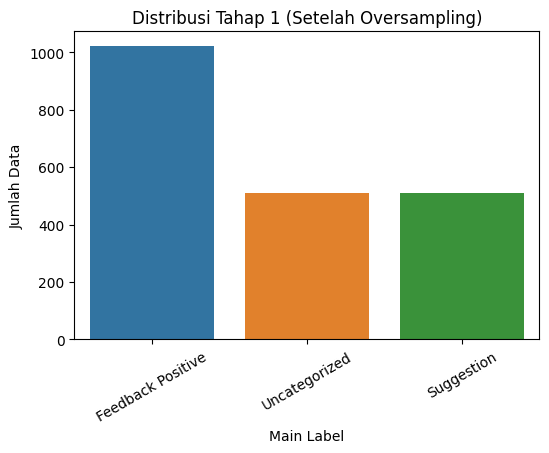

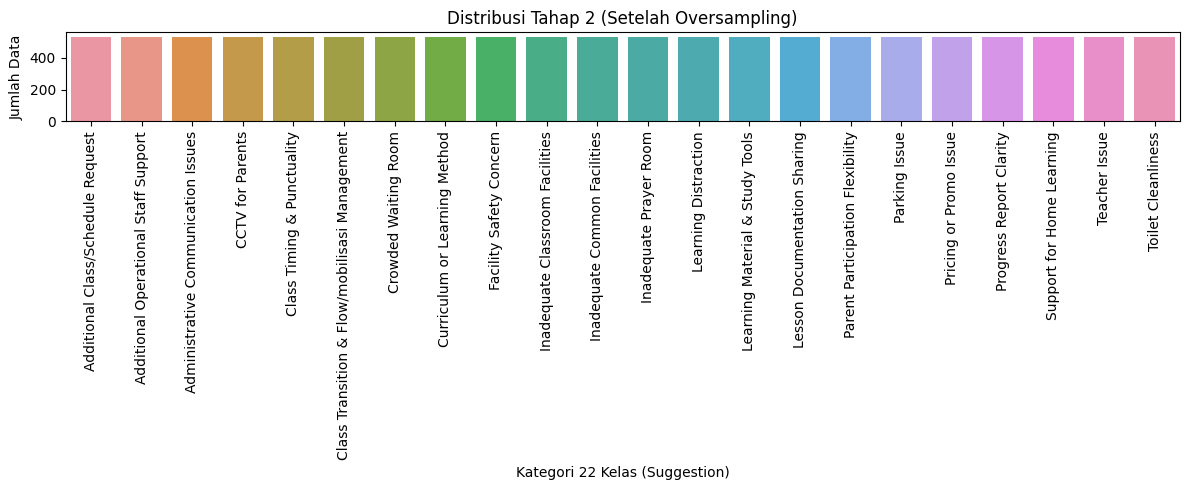

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# === Visualisasi distribusi tahap 1 (setelah oversampling) ===
plt.figure(figsize=(6,4))
sns.countplot(x="main_label", data=df_balanced, order=df_balanced["main_label"].value_counts().index)
plt.title("Distribusi Tahap 1 (Setelah Oversampling)")
plt.xlabel("Main Label")
plt.ylabel("Jumlah Data")
plt.xticks(rotation=30)
plt.show()

# === Visualisasi distribusi tahap 2 (setelah oversampling) ===
plt.figure(figsize=(12,5))
order_22 = df_multiclass_balanced["Category"].value_counts().index
sns.countplot(x="Category", data=df_multiclass_balanced, order=order_22)
plt.title("Distribusi Tahap 2 (Setelah Oversampling)")
plt.xlabel("Kategori 22 Kelas (Suggestion)")
plt.ylabel("Jumlah Data")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


In [4]:
# ============================
# 3. Training model tahap 1 (3 kelas)
# ============================
df_train_main, df_test_main = train_test_split(
    df_balanced,
    test_size=0.2,
    random_state=42,
    stratify=df_balanced["label_main"]
)

print("Jumlah data train:", len(df_train_main))
print("Jumlah data test :", len(df_test_main))

trainer_main = train_model(
    df_train_main,
    df_test_main,
    label_col="label_main",
    num_labels=len(label_encoder_main.classes_),
    id2label=id2label_main,
    label2id=label2id_main,
    model_save_dir="./results_main"
)

Jumlah data train: 1632
Jumlah data test : 409


tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Map:   0%|          | 0/1632 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Map:   0%|          | 0/409 [00:00<?, ? examples/s]

pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_36/786582226.py:181: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  trainer = WeightedTrainer(


model.safetensors:   0%|          | 0.00/498M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.496200,0.165351,0.948655,0.955982,0.939582,0.947191
2,0.077600,0.086929,0.970660,0.969136,0.972278,0.970684
3,0.027200,0.136613,0.968215,0.968871,0.967368,0.968110
4,0.004000,0.123365,0.975550,0.978632,0.972246,0.975282


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(



=== Evaluasi Model (./results_main) ===
eval_loss: 0.0869
eval_accuracy: 0.9707
eval_precision: 0.9691
eval_recall: 0.9723
eval_f1: 0.9707
eval_runtime: 1.1198
eval_samples_per_second: 365.2370
eval_steps_per_second: 11.6090
epoch: 4.0000


In [5]:
# ============================
# 4. Training model tahap 2 (22 kelas)
# ============================
df_train_multi, df_test_multi = train_test_split(
    df_multiclass_balanced,
    test_size=0.2,
    random_state=42,
    stratify=df_multiclass_balanced["label_22"]
)

print("Jumlah data train 2nd stage:", len(df_train_multi))
print("Jumlah data test 2nd stage:", len(df_test_multi))

trainer_multiclass = train_model(
    df_train_multi,
    df_test_multi,
    label_col="label_22",
    num_labels=len(label_encoder_22.classes_),
    id2label=id2label_22,
    label2id=label2id_22,
    model_save_dir="./results_multiclass"
)

Jumlah data train 2nd stage: 9416
Jumlah data test 2nd stage: 2354


Map:   0%|          | 0/9416 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Map:   0%|          | 0/2354 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_36/786582226.py:181: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  trainer = WeightedTrainer(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,1.011200,0.251599,0.946049,0.947425,0.946049,0.945011
2,0.136300,0.120960,0.967290,0.967314,0.967290,0.966477
3,0.049500,0.110970,0.974087,0.974277,0.974087,0.973681
4,0.031500,0.109086,0.975786,0.975996,0.975786,0.975423
5,0.021400,0.098586,0.980459,0.980469,0.980459,0.980369
6,0.019100,0.096638,0.978335,0.978190,0.978335,0.978097
7,0.016700,0.102826,0.977910,0.978042,0.977910,0.977704
8,0.014300,0.104385,0.976211,0.976133,0.976211,0.976032


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked t


=== Evaluasi Model (./results_multiclass) ===
eval_loss: 0.0966
eval_accuracy: 0.9783
eval_precision: 0.9782
eval_recall: 0.9783
eval_f1: 0.9781
eval_runtime: 7.3195
eval_samples_per_second: 321.6090
eval_steps_per_second: 10.1100
epoch: 8.0000
